# Tutorial #2 - Basic - Generating fingerprints and running multiple jobs

This tutorial will cover: 
* Running multiple jobs sequentially vs in parallel
* Generate different flavors of IFP and convert them to RDKit-like objects and then compute Tanimoto similarity
* Plotting heatmaps for summarizing the interactions
* Plotting a Pymol session for superposed complexes

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import os

### Set up system paths and import LUNA

In [2]:
LUNA_path = '/media/data/Workspace/LUNA' # change this to point to LUNA directory

import sys
sys.path.append(LUNA_path)

import luna

/home/alexandrefassio/miniconda3/envs/luna-env/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


### Reload the project created at Tutorial #1

In [3]:
proj_obj = luna.projects.LocalProject.load("./luna_results")

print("# Entries defined previously: ", len(proj_obj.entries))

for res in proj_obj.results:
    print(res.entry.to_string(), "  =>  # interactions: ", len(res.interactions_mngr))

[2021-06-14 01:08:16]    INFO            projects.py:583        Reloading project saved in './luna_results/project_v0.9.0.pkl.gz'.

[2021-06-14 01:08:16]    INFO            projects.py:320        Verbosity set to: 3 (INFO).
[2021-06-14 01:08:16]    INFO            projects.py:320        Project reloaded successfully.
# Entries defined previously:  5
D4:ZINC000012442563   =>  # interactions:  60
D4:ZINC000065293174   =>  # interactions:  52


/media/data/Workspace/LUNA/luna/projects.py:282: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


D4:ZINC000096459890   =>  # interactions:  48
D4:ZINC000343043015   =>  # interactions:  45
D4:ZINC000575033470   =>  # interactions:  68


### Create new Fingerprints

After reloading a project, you can create fingerprints without having to recalculate interactions. By doing so, you can create different fingerprints by varying the IFP parameters if you will.

In [4]:
from luna.mol.interaction.fp.type import IFPType

In [5]:
proj_obj.calc_ifp = True # interaction fingerprint

proj_obj.ifp_type = IFPType.EIFP # Type of fingerprints: EIFP, FIFP, or HIFP
proj_obj.ifp_count = True # Choose between count and bit fingerprint

proj_obj.ifp_num_levels = 6 # IFP parameter: number of levels
proj_obj.ifp_radius_step = 2 # IFP parameter: radius growth
proj_obj.ifp_length = 4096 # IFP parameter: size of the fingerprint

To create the fingerprints with the modified parameters, call the function **generate_ifps()**:

In [6]:
proj_obj.generate_ifps()

[2021-06-14 01:08:21]    INFO            projects.py:320        Preparing project directory '/media/data/Workspace/Projects/Keiser lab/Pfizer/keiserlab-pfizer/workshop/Jupyter notebook/luna_results'.
[2021-06-14 01:08:21]    INFO                file.py:102        The directory '/media/data/Workspace/Projects/Keiser lab/Pfizer/keiserlab-pfizer/workshop/Jupyter notebook/luna_results' already exists, but it will not be cleared.
[2021-06-14 01:08:21]    INFO                file.py:102        The directory '/media/data/Workspace/Projects/Keiser lab/Pfizer/keiserlab-pfizer/workshop/Jupyter notebook/luna_results/results' already exists, but it will not be cleared.
[2021-06-14 01:08:21]    INFO                file.py:102        The directory '/media/data/Workspace/Projects/Keiser lab/Pfizer/keiserlab-pfizer/workshop/Jupyter notebook/luna_results/results/fingerprints' already exists, but it will not be cleared.
[2021-06-14 01:08:21]    INFO            projects.py:320        Project directory '/

[2021-06-14 01:08:21]    INFO            projects.py:320        Logging file '/media/data/Workspace/Projects/Keiser lab/Pfizer/keiserlab-pfizer/workshop/Jupyter notebook/luna_results/logs/project.log' initialized successfully.
[2021-06-14 01:08:21]    INFO            projects.py:320        Fingerprint generation will start. Number of entries to be processed is: 5.
[2021-06-14 01:08:21]    INFO            projects.py:320        The number of processes was set to: None.


[2021-06-14 01:08:26]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 5/5 [Avg: 1.06s/task; Errors: 0] - Fingerprint generation.

[2021-06-14 01:08:26]    INFO            projects.py:320        Fingerprint generation finished successfully.


[2021-06-14 01:08:26]    INFO            projects.py:320        Total processing time: 5.82s.
[2021-06-14 01:08:26]    INFO            projects.py:320        Results were saved at /media/data/Workspace/Projects/Keiser lab/Pfizer/keiserlab-pfizer/workshop/Jupyter notebook/luna_results.




The default output is saved at <WORKING-PATH>/results/fingerprints/ifp.csv, but you can also indicate the output filename if you will.


In [ ]:
proj_obj.ifp_output = "./outputs/new_output_file.csv"

### Evaluate results

The results for each individual entry can be accessed through the EntryResult.

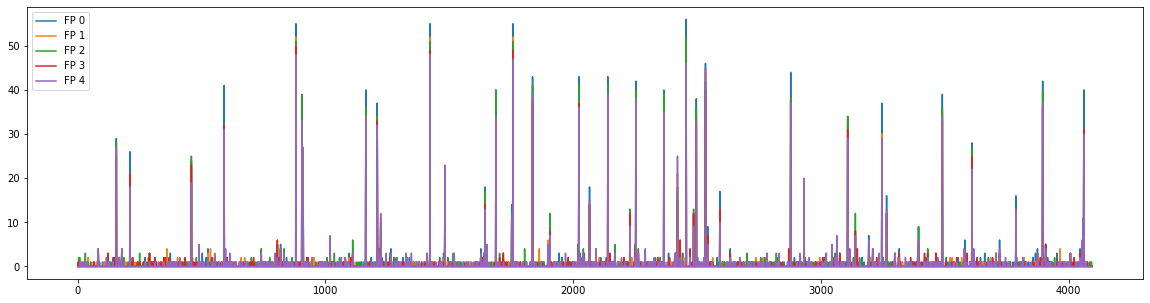

In [8]:
fig, ax = plt.subplots(figsize=(20, 5))

for i, entry in enumerate(proj_obj.entries):
    fp = proj_obj.get_entry_results(entry).ifp
    plot_vals = [fp.counts[i] if i in fp.counts else 0 for i in range(1, fp.fp_length + 1)]
    ax.plot(plot_vals, label = f"FP {i}")
plt.legend()

#### Density - how populated is the fingerprint

(array([2., 1., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([0.109375  , 0.11115723, 0.11293945, 0.11472168, 0.11650391,
        0.11828613, 0.12006836, 0.12185059, 0.12363281, 0.12541504,
        0.12719727]),
 <a list of 10 Patch objects>)

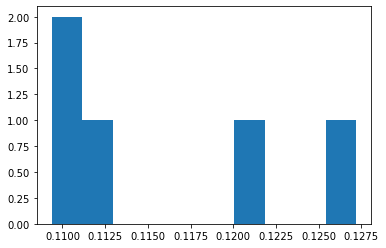

In [17]:
densities = [proj_obj.get_entry_results(entry).ifp.density for entry in proj_obj.entries]
plt.hist(densities)

#### Tanimoto coefficient - how similar are two fingerprints

You can calculate the similarity between two fingerprints using the function **calc_similarity()** from the fingerprint object.

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 2.]),
 array([0.20952381, 0.21198669, 0.21444958, 0.21691246, 0.21937535,
        0.22183823, 0.22430112, 0.226764  , 0.22922688, 0.23168977,
        0.23415265]),
 <a list of 10 Patch objects>)

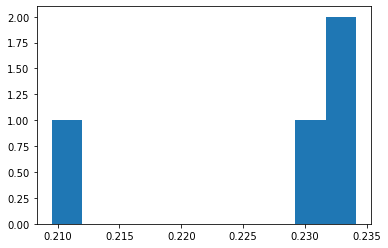

In [7]:
# Get a list of tuples where the first element is an entry and the second is an IFP.
ifps = list(proj_obj.ifps)

tanimotos = [ifps[0][1].calc_similarity(ifps[i][1]) for i in range(1,5)]

plt.hist(tanimotos)

## Export shells to Pymol sessions

To export shells to Pymol, you first need to create a **ShellGenerator** object that create shells for a given entry. As a result, it produces a **ShellManager** object. With a ShellManager you can access the created shells, create fingerprints, and trace back bit positions at a fingerprint back to its original shell.

In [8]:
from luna.mol.interaction.fp.shell import ShellGenerator
from luna.mol.interaction.fp.view import ShellViewer

In [9]:
target_entry = proj_obj.entries[0]
agm = proj_obj.get_entry_results(target_entry).atm_grps_mngr

sg = ShellGenerator(proj_obj.ifp_num_levels, proj_obj.ifp_radius_step, diff_comp_classes=proj_obj.ifp_diff_comp_classes, ifp_type=proj_obj.ifp_type)
sm = sg.create_shells(agm)

print("# shells: ", len(sm.shells))

# shells:  1963


In [11]:
psv = ShellViewer(add_directional_arrows=False)

# Let's select some shells. In this example, we are selecting only unique shells at level 4.
shells = sm.get_shells_by_level(4, unique_shells=True)
print("# shells at level 4: ", len(shells))

# Create a list of tuples, where the first item is the entry and the second item is the shells you want to visualize.
# In this example, let's visualize just the first five selected shells.
shell_tuples = [(target_entry, shells[0:6], proj_obj.pdb_path)]

# Define the output file. Note that all shells will be saved at the same Pymol session.
pse_file = "./outputs/shells_at_level4.pse"
psv.new_session(shell_tuples, pse_file)

# shells at level 4:  63
 PyMOL not running, entering library mode (experimental)
 Applying pse_export_version=1.800 compatibility


## Trace back a feature to its shell

To trace a feature in the fingerprint back to its shell, you need to use the function **trace_back_feature()** available at ShellManager objects.

In [15]:
ifp = sm.to_fingerprint(fold_to_size=4096, unique_shells=True, count_fp=False)

# Trace back the first feature set ON in the fingerprint.
recoved_shells = sm.trace_back_feature(ifp.get_on_bits()[0], ifp)

# As collisions may occur in a fingerprint, the trace_back_feature returns all shells collided in a given feature id.
for ori_feature, found_shells in recoved_shells:
    print("Shell id: %s" % ori_feature)
    print("  - Number of shells containing this id: %d." % len(found_shells))
    print()

Shell id: 3672809493
  - Number of shells containing this id: 1.

